In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as scs
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'

In [2]:
def add_one(ary):
    """Input: 1-d array
    Output: 2d array, 0th column all 1s."""
    
    return np.vstack((np.ones_like(ary),ary)).T

class LoglinearModel:
        
    def fit(self, x, y):
        X = sm.add_constant(x)
        
        mod = sm.OLS(np.log(y), X)
        res = mod.fit()
        
        self.params = res.params
        self.cov = res.cov_params()
    
    def __call__(self, x):
        return np.exp(add_one(x) @ self.params )
    
    def sample(self, x, n_samples=100):
        norm = scs.multivariate_normal(mean=self.params, cov=self.cov)
        param_samples = norm.rvs(n_samples)
        
        return np.exp(add_one(x) @ param_samples.T)

In [3]:
data_filename = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"

df = pd.read_csv(data_filename)
df["date"] = pd.to_datetime(df["date"])

In [4]:
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [5]:
state_pop_df = pd.read_csv("data/state_pop.csv", skiprows=1)
state_pop_df["fips"] = state_pop_df["id"].str[-2:].astype(int)

In [6]:
TEST_LAG = 8
DEATH_LAG = 18
DETECTION_PROB = 1/8
DEATH_PROB = 1/50
STATE_FIPS = 53

CASES_MIN = 300
DEATH_MIN = 10
TEST_TRUSTWORTHY_START = 50
DEATH_TRUSTWORTHY_START = 46

STATE = "Washington"

df_state = df[df.state==STATE]

date0 = df_state.iloc[0].date

case_plot = df_state[ df_state.cases >= CASES_MIN ]
death_plot = df_state[ df_state.deaths >= DEATH_MIN ]

test_day = (case_plot.date-date0).dt.days-TEST_LAG
test_results = case_plot.cases/DETECTION_PROB

death_day = (death_plot.date-date0).dt.days-DEATH_LAG
death_results = death_plot.deaths/DEATH_PROB

In [8]:
all_days = np.concatenate( [test_day, death_day] )
all_results = np.concatenate( [test_results, death_results] )

infection_pred = LoglinearModel()
infection_pred.fit( all_days, all_results )

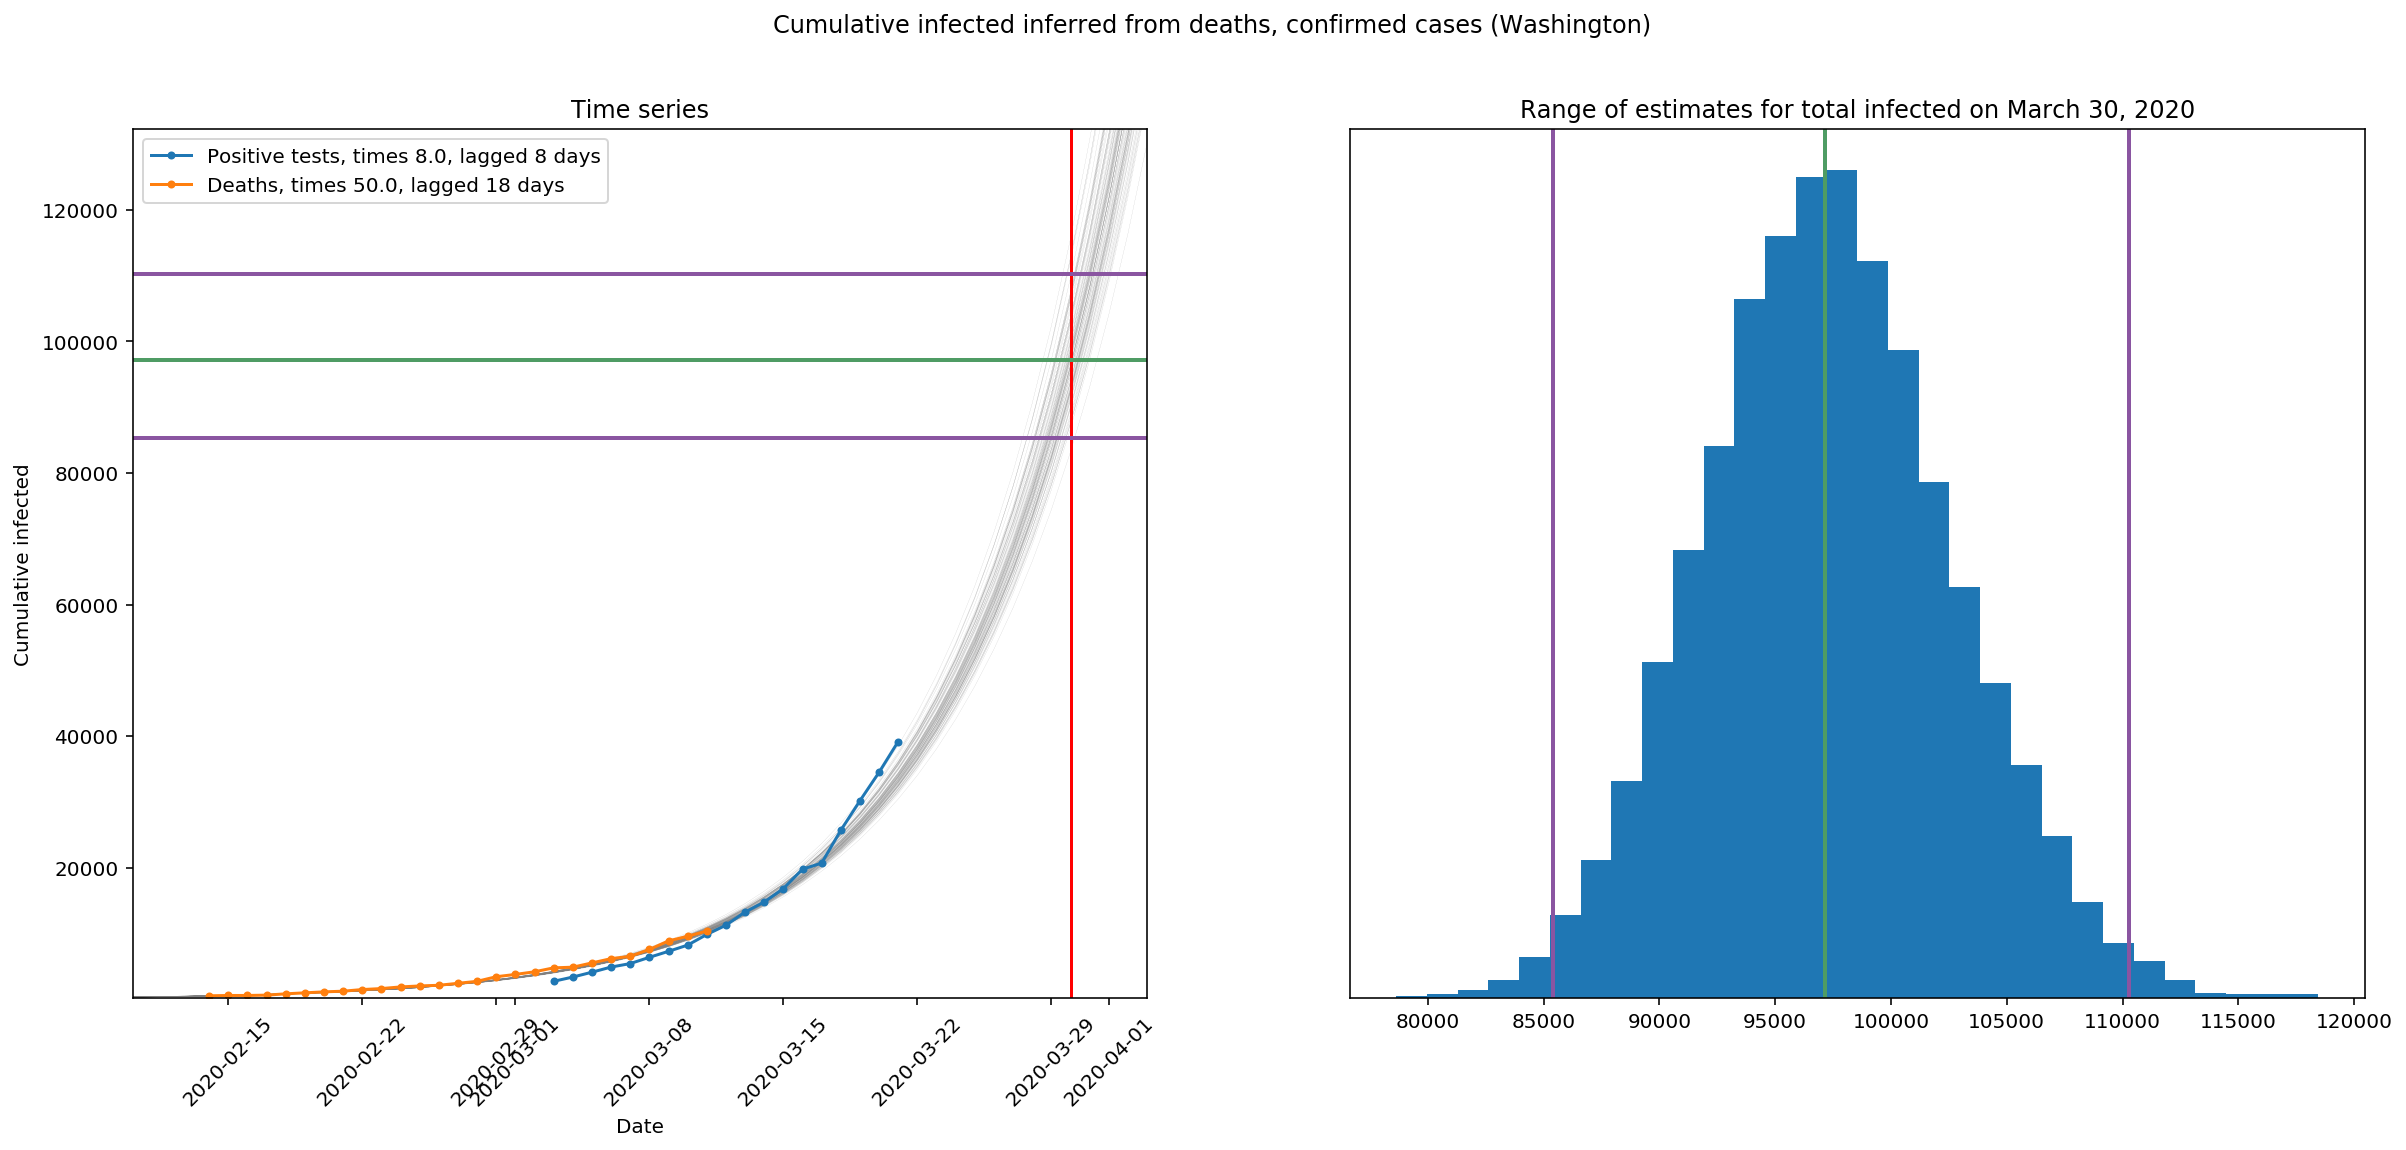

In [35]:
TODAY = "March 30, 2020"
OUTER_EST_COLOR = "#8a55a1"
MEDIAN_EST_COLOR = "#4f9c64"
N_SAMPLES = 10000

today_days = (pd.to_datetime( datetime.today() ) - date0).days

total_infected_samples = infection_pred.sample(today_days, n_samples=N_SAMPLES)[0]
est_low, est_med, est_high = np.percentile( total_infected_samples, [1, 50, 99])

fig, axs = plt.subplots(1, 2, figsize=(20,8))

ax = axs[0]

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title("Time series")

dayspace = np.arange(-5,80)
for trace in infection_pred.sample(dayspace).T:
    ax.plot(date0+dayspace*timedelta(days=1), trace, c="gray", lw=0.05)

ax.plot( date0+test_day*timedelta(days=1), 
        test_results, label="Positive tests, times %s, lagged %s days"%(1/DETECTION_PROB, TEST_LAG), marker="." )
ax.plot( date0+death_day*timedelta(days=1), 
        death_results, label="Deaths, times %s, lagged %s days"%(1/DEATH_PROB, DEATH_LAG), marker="." )

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative infected")
ax.legend()
#ax.semilogy()
ax.set_ylim(100,est_high*1.2)
ax.set_xlim("February 10, 2020", "April 3, 2020")

ax.axvline(TODAY, c="red")
ax.axhline(est_low, c=OUTER_EST_COLOR, lw=2)
ax.axhline(est_med, c=MEDIAN_EST_COLOR, lw=2)
ax.axhline(est_high, c=OUTER_EST_COLOR, lw=2)


ax = axs[1]
ax.hist( total_infected_samples, bins=30, density=True )
ax.set_yticks([])
ax.set_title("Range of estimates for total infected on %s"%TODAY)
ax.axvline(est_low, c=OUTER_EST_COLOR, lw=2)
ax.axvline(est_med, c=MEDIAN_EST_COLOR, lw=2)
ax.axvline(est_high, c=OUTER_EST_COLOR, lw=2)

plt.suptitle("Cumulative infected inferred from deaths, confirmed cases (%s)"%STATE)

None

In [31]:
pop = state_pop_df[state_pop_df["Geographic Area Name"]==STATE].iloc[0]["Estimate!!Total"]

In [32]:
perc_low, perc_med, perc_high = 100*np.array([est_low, est_med, est_high])/pop

In [33]:
"Total infected prevalence: %0.2f%% (95%% confidence %0.2f%%-%0.2f%%)"%(perc_med, perc_low, perc_high)

'Total infected prevalence: 1.29% (95% confidence 1.13%-1.46%)'

Quick sanity check - estimate should be 8x the last tested value, with some number of doubling times added on...

In [57]:
DOUBLING_TIME = 6.3
df[df.state==STATE].iloc[-1].cases*(2**(TEST_LAG/DOUBLING_TIME))/DETECTION_PROB

94447.76995712721